
# Additive Synthesis

**Author**: [Moto Hira](moto@meta.com)_

This tutorial is the continuation of
[Oscillator and ADSR Envelope](./oscillator_tutorial.html)_.

This tutorial shows how to perform additive synthesis and subtractive
synthesis using TorchAudio's DSP functions.

Additive synthesis creates timbre by combining multiple waveform.
Subtractive synthesis creates timbre by applying filters.

<div class="alert alert-danger"><h4>Warning</h4><p>This tutorial requires prototype DSP features, which are
   available in nightly builds.

   Please refer to https://pytorch.org/get-started/locally
   for instructions for installing a nightly build.</p></div>


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.3.0.dev20240222
2.2.0.dev20240222


## Overview





In [2]:
try:
    from torchaudio.prototype.functional import adsr_envelope, extend_pitch, oscillator_bank
except ModuleNotFoundError:
    print(
        "Failed to import prototype DSP features. "
        "Please install torchaudio nightly builds. "
        "Please refer to https://pytorch.org/get-started/locally "
        "for instructions to install a nightly build."
    )
    raise

import matplotlib.pyplot as plt
from IPython.display import Audio

## Creating multiple frequency pitches

The core of additive synthesis is oscillator. We create a timbre by
summing up the multiple waveforms generated by oscillator.

In [the oscillator tutorial](./oscillator_tutorial.html)_, we used
:py:func:`~torchaudio.prototype.functional.oscillator_bank` and
:py:func:`~torchaudio.prototype.functional.adsr_envelope` to generate
various waveforms.

In this tutorial, we use
:py:func:`~torchaudio.prototype.functional.extend_pitch` to create
a timbre from base frequency.




First, we define some constants and helper function that we use
throughout the tutorial.



In [3]:
PI = torch.pi
PI2 = 2 * torch.pi

F0 = 344.0  # fundamental frequency
DURATION = 1.1  # [seconds]
SAMPLE_RATE = 16_000  # [Hz]

NUM_FRAMES = int(DURATION * SAMPLE_RATE)

In [4]:
def plot(freq, amp, waveform, sample_rate, zoom=None, vol=0.1):
    t = (torch.arange(waveform.size(0)) / sample_rate).numpy()

    fig, axes = plt.subplots(4, 1, sharex=True)
    axes[0].plot(t, freq.numpy())
    axes[0].set(title=f"Oscillator bank (bank size: {amp.size(-1)})", ylabel="Frequency [Hz]", ylim=[-0.03, None])
    axes[1].plot(t, amp.numpy())
    axes[1].set(ylabel="Amplitude", ylim=[-0.03 if torch.all(amp >= 0.0) else None, None])
    axes[2].plot(t, waveform)
    axes[2].set(ylabel="Waveform")
    axes[3].specgram(waveform, Fs=sample_rate)
    axes[3].set(ylabel="Spectrogram", xlabel="Time [s]", xlim=[-0.01, t[-1] + 0.01])

    for i in range(4):
        axes[i].grid(True)
    pos = axes[2].get_position()
    fig.tight_layout()

    if zoom is not None:
        ax = fig.add_axes([pos.x0 + 0.02, pos.y0 + 0.03, pos.width / 2.5, pos.height / 2.0])
        ax.plot(t, waveform)
        ax.set(xlim=zoom, xticks=[], yticks=[])

    waveform /= waveform.abs().max()
    return Audio(vol * waveform, rate=sample_rate, normalize=False)

## Harmonic Overtones

Harmonic overtones are frequency components that are an integer
multiple of the fundamental frequency.

We look at how to generate the common waveforms that are used in
synthesizers. That is,

 - Sawtooth wave
 - Square wave
 - Triangle wave




### Sawtooth wave

[Sawtooth wave](https://en.wikipedia.org/wiki/Sawtooth_wave) can be
expressed as the following. It contains all the integer harmonics, so
it is commonly used in subtractive synthesis as well.

\begin{align}\begin{align*}
   y_t &= \sum_{k=1}^{K} A_k \sin ( 2 \pi f_k t ) \\
   \text{where} \\
   f_k &= k f_0 \\
   A_k &= -\frac{ (-1) ^k }{k \pi}
   \end{align*}\end{align}




The following function takes fundamental frequencies and amplitudes,
and adds extend pitch in accordance with the formula above.




In [5]:
def sawtooth_wave(freq0, amp0, num_pitches, sample_rate):
    freq = extend_pitch(freq0, num_pitches)

    mults = [-((-1) ** i) / (PI * i) for i in range(1, 1 + num_pitches)]
    amp = extend_pitch(amp0, mults)
    waveform = oscillator_bank(freq, amp, sample_rate=sample_rate)
    return freq, amp, waveform

Now synthesize a waveform




/Users/fra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchaudio/prototype/functional/_dsp.py:63: UserWarning: Some frequencies are above nyquist frequency. Setting the corresponding amplitude to zero. This might cause numerically unstable gradient.
  warnings.warn(


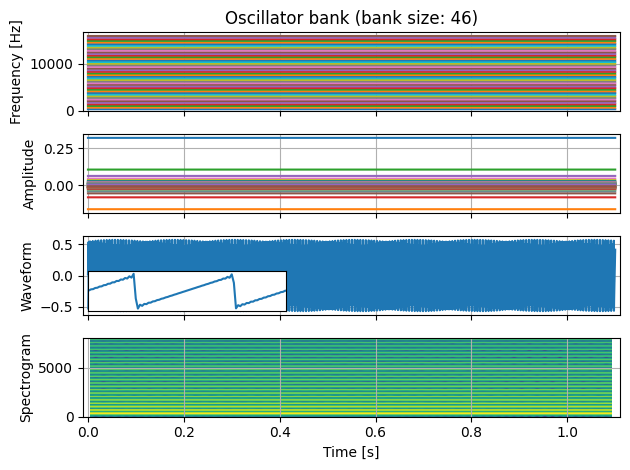

In [6]:
freq0 = torch.full((NUM_FRAMES, 1), F0)
amp0 = torch.ones((NUM_FRAMES, 1))
freq, amp, waveform = sawtooth_wave(freq0, amp0, int(SAMPLE_RATE / F0), SAMPLE_RATE)
plot(freq, amp, waveform, SAMPLE_RATE, zoom=(1 / F0, 3 / F0))

It is possible to oscillate the base frequency to create a
time-varying tone based on sawtooth wave.




/Users/fra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchaudio/prototype/functional/_dsp.py:63: UserWarning: Some frequencies are above nyquist frequency. Setting the corresponding amplitude to zero. This might cause numerically unstable gradient.
  warnings.warn(


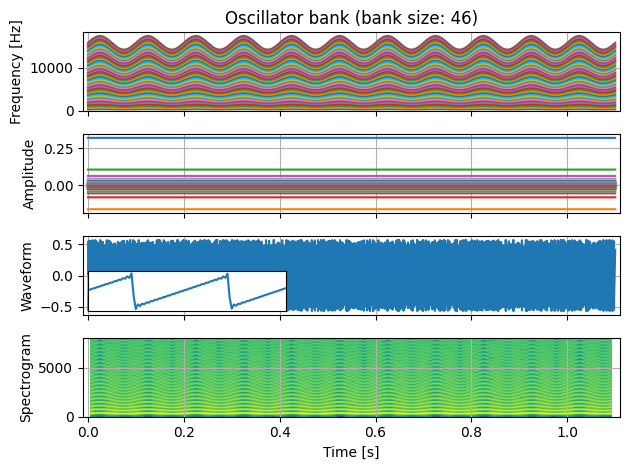

In [7]:
fm = 10  # rate at which the frequency oscillates [Hz]
f_dev = 0.1 * F0  # the degree of frequency oscillation [Hz]

phase = torch.linspace(0, fm * PI2 * DURATION, NUM_FRAMES)
freq0 = F0 + f_dev * torch.sin(phase).unsqueeze(-1)

freq, amp, waveform = sawtooth_wave(freq0, amp0, int(SAMPLE_RATE / F0), SAMPLE_RATE)
plot(freq, amp, waveform, SAMPLE_RATE, zoom=(1 / F0, 3 / F0))

### Square wave

[Square wave](https://en.wikipedia.org/wiki/Square_wave) contains
only odd-integer harmonics.

\begin{align}\begin{align*}
   y_t &= \sum_{k=0}^{K-1} A_k \sin ( 2 \pi f_k t ) \\
   \text{where} \\
   f_k &= n f_0 \\
   A_k &= \frac{ 4 }{n \pi} \\
   n   &= 2k + 1
   \end{align*}\end{align}



In [8]:
def square_wave(freq0, amp0, num_pitches, sample_rate):
    mults = [2.0 * i + 1.0 for i in range(num_pitches)]
    freq = extend_pitch(freq0, mults)

    mults = [4 / (PI * (2.0 * i + 1.0)) for i in range(num_pitches)]
    amp = extend_pitch(amp0, mults)

    waveform = oscillator_bank(freq, amp, sample_rate=sample_rate)
    return freq, amp, waveform

/Users/fra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchaudio/prototype/functional/_dsp.py:63: UserWarning: Some frequencies are above nyquist frequency. Setting the corresponding amplitude to zero. This might cause numerically unstable gradient.
  warnings.warn(


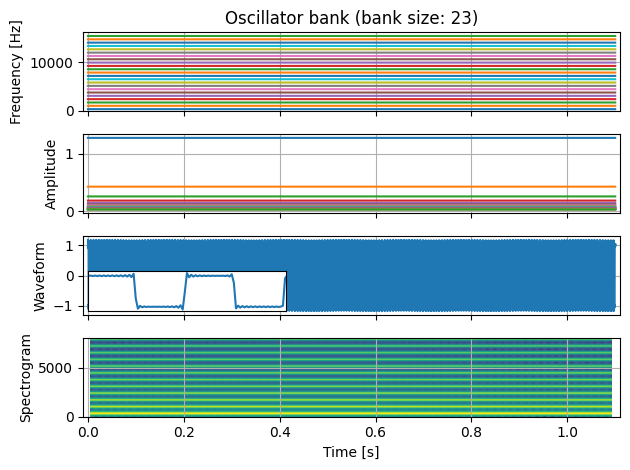

In [9]:
freq0 = torch.full((NUM_FRAMES, 1), F0)
amp0 = torch.ones((NUM_FRAMES, 1))
freq, amp, waveform = square_wave(freq0, amp0, int(SAMPLE_RATE / F0 / 2), SAMPLE_RATE)
plot(freq, amp, waveform, SAMPLE_RATE, zoom=(1 / F0, 3 / F0))

### Triangle wave

[Triangle wave](https://en.wikipedia.org/wiki/Triangle_wave)
also only contains odd-integer harmonics.

\begin{align}\begin{align*}
   y_t &= \sum_{k=0}^{K-1} A_k \sin ( 2 \pi f_k t ) \\
   \text{where} \\
   f_k &= n f_0 \\
   A_k &= (-1) ^ k \frac{8}{(n\pi) ^ 2} \\
   n   &= 2k + 1
   \end{align*}\end{align}



In [10]:
def triangle_wave(freq0, amp0, num_pitches, sample_rate):
    mults = [2.0 * i + 1.0 for i in range(num_pitches)]
    freq = extend_pitch(freq0, mults)

    c = 8 / (PI**2)
    mults = [c * ((-1) ** i) / ((2.0 * i + 1.0) ** 2) for i in range(num_pitches)]
    amp = extend_pitch(amp0, mults)

    waveform = oscillator_bank(freq, amp, sample_rate=sample_rate)
    return freq, amp, waveform

/Users/fra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchaudio/prototype/functional/_dsp.py:63: UserWarning: Some frequencies are above nyquist frequency. Setting the corresponding amplitude to zero. This might cause numerically unstable gradient.
  warnings.warn(


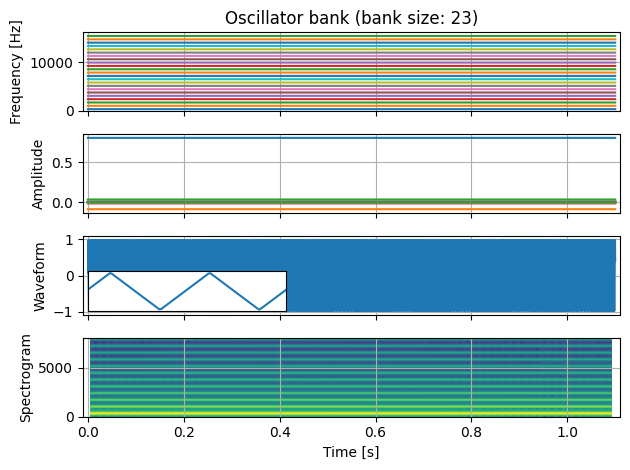

In [11]:
freq, amp, waveform = triangle_wave(freq0, amp0, int(SAMPLE_RATE / F0 / 2), SAMPLE_RATE)
plot(freq, amp, waveform, SAMPLE_RATE, zoom=(1 / F0, 3 / F0))

## Inharmonic Paritials

Inharmonic partials refer to freqencies that are not integer multiple
of fundamental frequency.

They are essential in re-creating realistic sound or
making the result of synthesis more interesting.




### Bell sound

https://computermusicresource.com/Simple.bell.tutorial.html




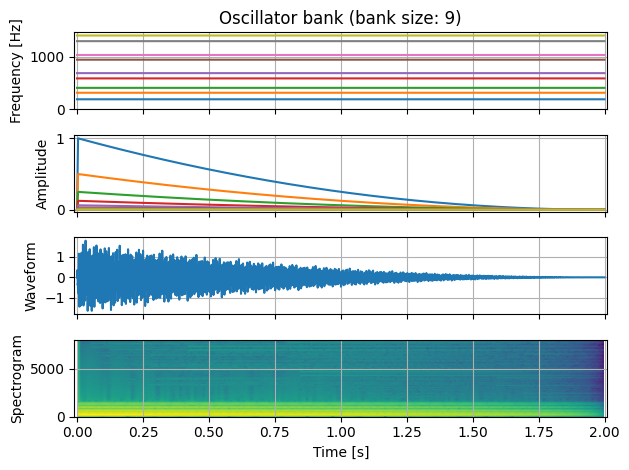

In [12]:
num_tones = 9
duration = 2.0
num_frames = int(SAMPLE_RATE * duration)

freq0 = torch.full((num_frames, 1), F0)
mults = [0.56, 0.92, 1.19, 1.71, 2, 2.74, 3.0, 3.76, 4.07]
freq = extend_pitch(freq0, mults)

amp = adsr_envelope(
    num_frames=num_frames,
    attack=0.002,
    decay=0.998,
    sustain=0.0,
    release=0.0,
    n_decay=2,
)
amp = torch.stack([amp * (0.5**i) for i in range(num_tones)], dim=-1)

waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

plot(freq, amp, waveform, SAMPLE_RATE, vol=0.4)

As a comparison, the following is the harmonic version of the above.
Only frequency values are different.
The number of overtones and its amplitudes are same.




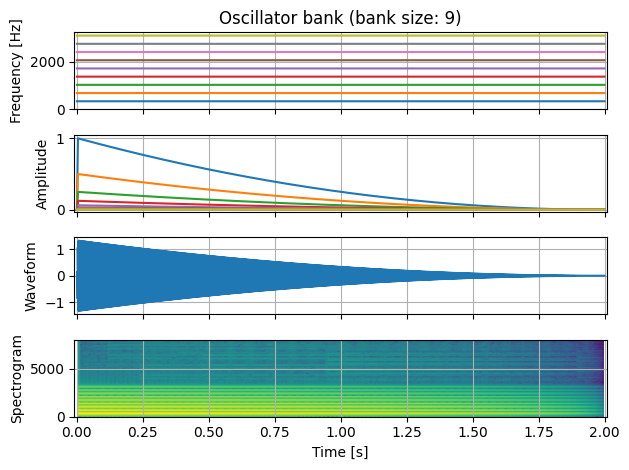

In [13]:
freq = extend_pitch(freq0, num_tones)
waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

plot(freq, amp, waveform, SAMPLE_RATE)

## References

- https://en.wikipedia.org/wiki/Additive_synthesis
- https://computermusicresource.com/Simple.bell.tutorial.html
- https://computermusicresource.com/Definitions/additive.synthesis.html

